# Lab 2

## Setup

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

RAW_DIR = "/content/drive/MyDrive/Edu/CM1001 Applied Machine Learning and Data Mining/Doppler-Data/raw/"
MASK_DIR = "/content/drive/MyDrive/Edu/CM1001 Applied Machine Learning and Data Mining/Doppler-Data/mask/"
IMAGE_SIZE = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load images

#### Match 

Match the geiven masks with the raw images.

Each mask has two raw images.
The raw images that remains are used for testing later. 

In [ ]:
raws_filepaths = []
masks_filepaths = []
raws_filepaths_nomatch = []
masks_filepaths_nomatch = []

for raw_filename in os.listdir(RAW_DIR):

    first_crop = raw_filename[0:4]
    last_crop = raw_filename[len(raw_filename) - 10:len(raw_filename) - 4]


    did_match = False

    for mask_filename in os.listdir(MASK_DIR):
      if first_crop in mask_filename and last_crop in mask_filename:
        masks_filepaths.append(mask_filename)
        did_match = True
      
    if did_match:
      raws_filepaths.append(raw_filename)
    else:
      raws_filepaths_nomatch.append(raw_filename)




print('All raws: ' + str(len(os.listdir(RAW_DIR))))
print('All masks: ' + str(len(os.listdir(MASK_DIR))))
print('raws_filepaths: ' + str(len(raws_filepaths)))
print('masks_filepaths: ' + str(len(masks_filepaths)))
print('masks_filepaths_nomatch: ' + str(len(raws_filepaths_nomatch)))
print('masks_filepaths_nomatch: ' + str(len(masks_filepaths_nomatch)))



All raws: 414
All masks: 153
raws_filepaths: 306
masks_filepaths: 306
masks_filepaths_nomatch: 108
masks_filepaths_nomatch: 0


Actually loading

In [ ]:
raws = []
masks = []
raws_nomatch = []
masks_nomatch = []

def load_from_paths(base, paths):
  print('Loading '  + str(len(paths)) + ' images')
  result = []
  for image in paths:
    pix_arr = cv2.imread(os.path.join(base, image), cv2.IMREAD_GRAYSCALE)
    pix_arr = cv2.resize(pix_arr, (IMAGE_SIZE, IMAGE_SIZE))
    result.append(pix_arr)  
  return np.array(result)
  
raws = load_from_paths(RAW_DIR, raws_filepaths)
masks = load_from_paths(MASK_DIR, masks_filepaths)
raws_nomatch = load_from_paths(RAW_DIR, raws_filepaths_nomatch)
masks_nomatch = load_from_paths(MASK_DIR, masks_filepaths_nomatch)

print('Raw shape: ', raws.shape)
print('Mask shape: ', masks.shape)
print('Raw shape (no match): ', raws_nomatch.shape)
print('Mask shape (no match): ', masks_nomatch.shape)

Loading 306 images
Loading 306 images
Loading 108 images
Loading 0 images
Raw shape:  (306, 128, 128)
Mask shape:  (306, 128, 128)
Raw shape (no match):  (108, 128, 128)
Mask shape (no match):  (0,)


Normalize each images before inputtning in our model

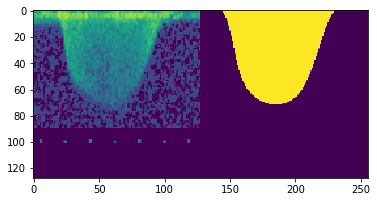

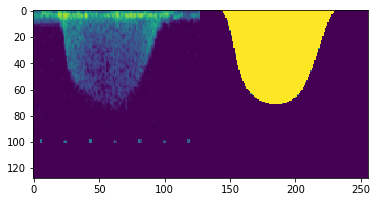

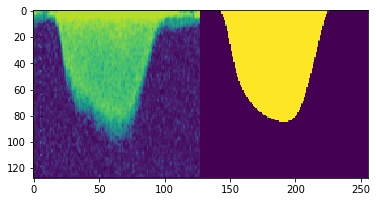

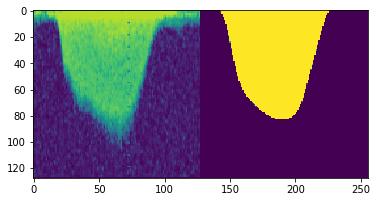

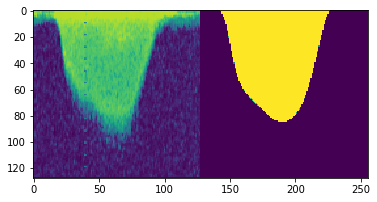

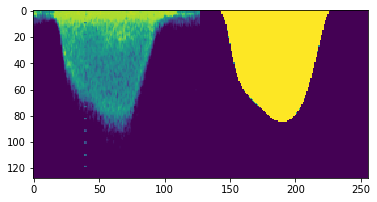

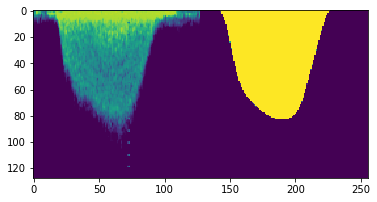

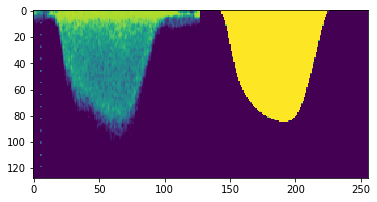

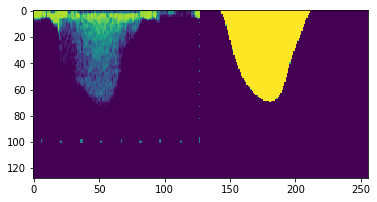

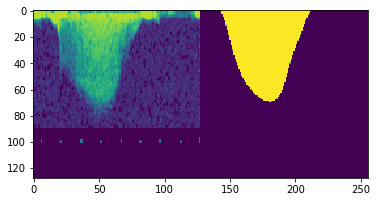

In [ ]:
def normalize(pixels):
  pixels = pixels.astype('float32')
  pixels /= 255
  return pixels

masks = masks.astype('float32')
masks /= 255
raws = raws.astype('float32')
raws /= 255
masks_nomatch = masks_nomatch.astype('float32')
masks_nomatch /= 255
raws_nomatch = raws_nomatch.astype('float32')
raws_nomatch /= 255

for i in range(10):
  plt.imshow(np.concatenate((raws[i], masks[i]), axis=1), interpolation='nearest')
  plt.show()

## Setup model
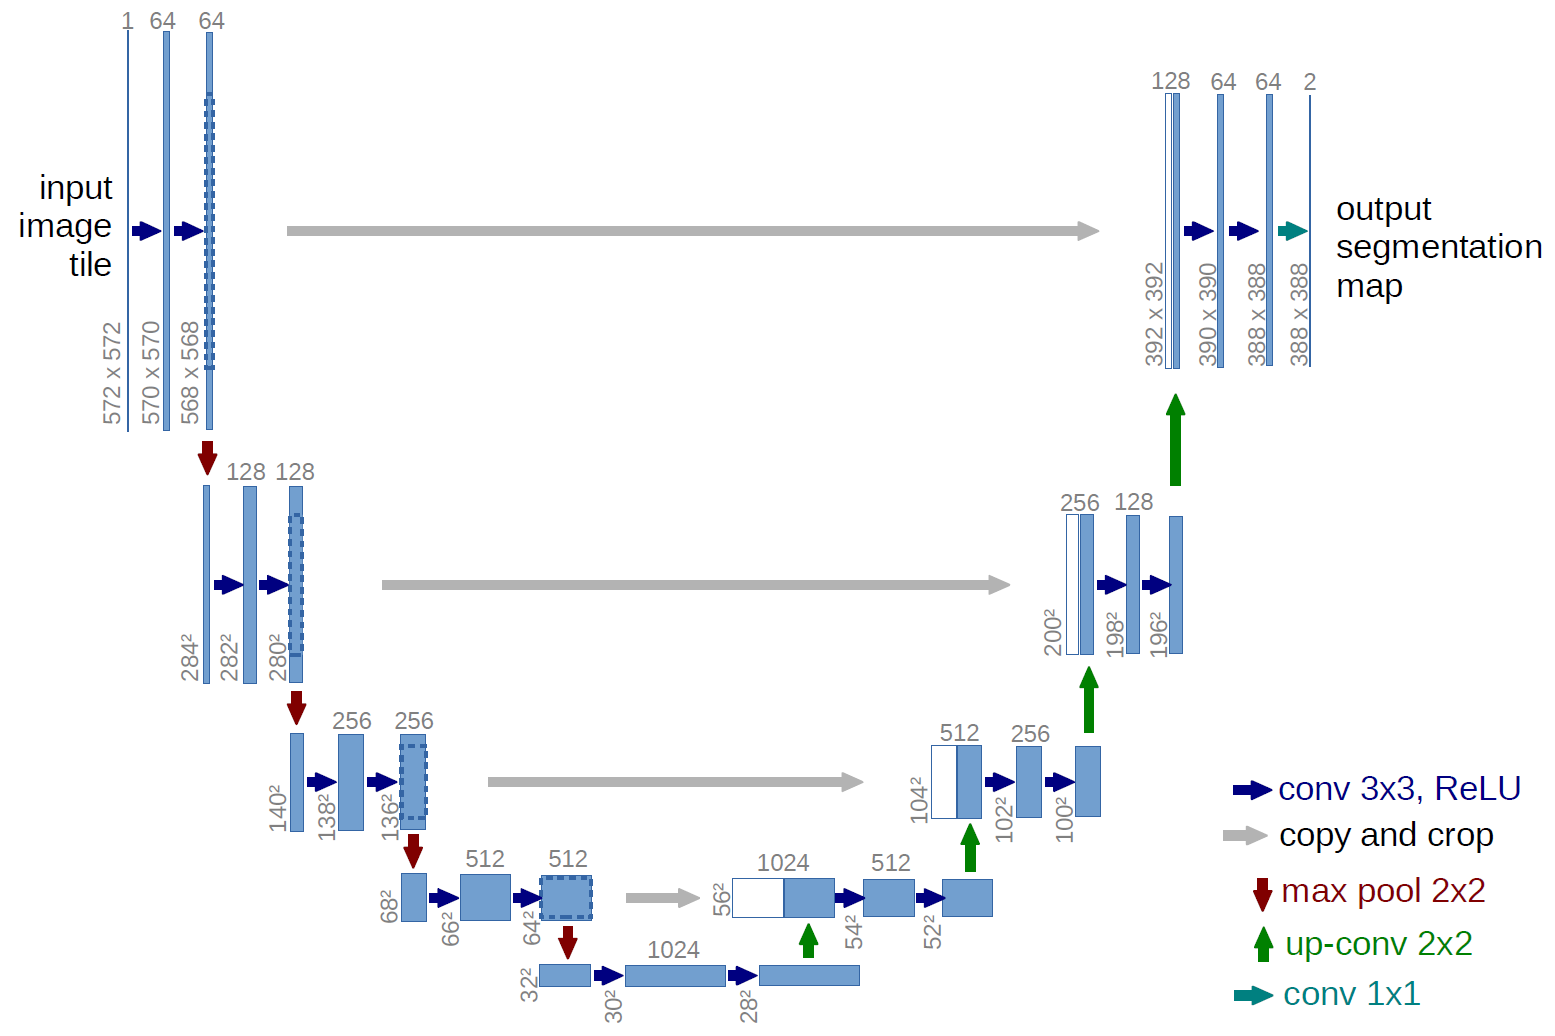

In [ ]:
from keras.models import *
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

input_size = (IMAGE_SIZE, IMAGE_SIZE, 1)
kernel_size = (3, 3)
activation = 'relu'
padding='same'
pool_size = (2, 2)
up_size = (2,2)


### Setup layers

In [ ]:
layers = []

layers.append(Input(input_size))

for filter_size in (64, 128, 256, 512):
  layers.append(Conv2D(filter_size, kernel_size=kernel_size, activation=activation, padding=padding))
  layers.append(MaxPooling2D(pool_size = pool_size))
  
for filter_size in (1024, 512, 256, 128):
  layers.append(Conv2D(filter_size, kernel_size=kernel_size, activation=activation, padding=padding))
  layers.append(UpSampling2D(size=up_size))
  
layers.append(Conv2D(128, kernel_size=kernel_size, activation=activation, padding=padding))

layers.append(Conv2D(1, (1, 1), activation='sigmoid', padding=padding))

### Build

In [ ]:
model = Sequential(layers)
model.build(input_size)

### Summarize

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 256)     

## Train model

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

split = 250

history = model.fit(raws[:split], 
                    masks[:split], 
                    epochs=11,
                    validation_data=(raws[split:], masks[split:]))

Epoch 1/11
8/8 [==============================] - 5s 497ms/step - loss: 0.1932 - accuracy: 0.9561 - val_loss: 0.1058 - val_accuracy: 0.9764
Epoch 2/11
8/8 [==============================] - 4s 451ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 0.0501 - val_accuracy: 0.9797
Epoch 3/11
8/8 [==============================] - 4s 451ms/step - loss: 0.0517 - accuracy: 0.9788 - val_loss: 0.0424 - val_accuracy: 0.9815
Epoch 4/11
8/8 [==============================] - 4s 451ms/step - loss: 0.0436 - accuracy: 0.9810 - val_loss: 0.0402 - val_accuracy: 0.9834
Epoch 5/11
8/8 [==============================] - 4s 458ms/step - loss: 0.0387 - accuracy: 0.9832 - val_loss: 0.0419 - val_accuracy: 0.9830
Epoch 6/11
8/8 [==============================] - 4s 470ms/step - loss: 0.0374 - accuracy: 0.9837 - val_loss: 0.0356 - val_accuracy: 0.9855
Epoch 7/11
8/8 [==============================] - 4s 457ms/step - loss: 0.0329 - accuracy: 0.9856 - val_loss: 0.0328 - val_accuracy: 0.9866
Epoch 8/11
8/8 [====

2/2 - 0s - loss: 0.0324 - accuracy: 0.9860 - 340ms/epoch - 170ms/step


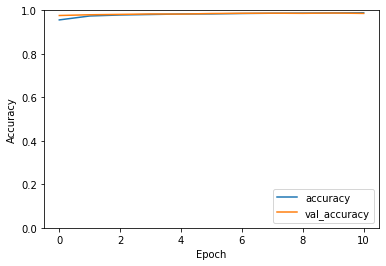

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(raws[split:],  masks[split:], verbose=2)

### Predict

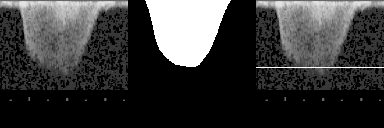

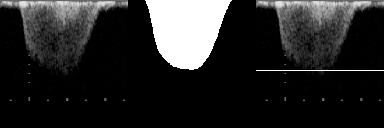

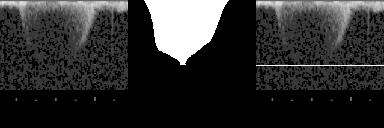

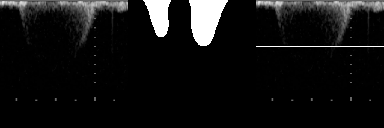

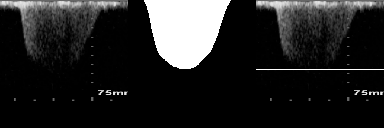

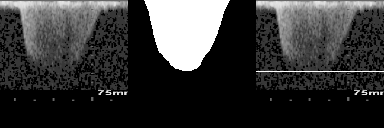

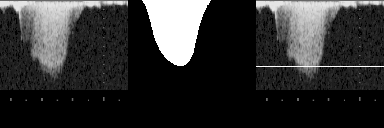

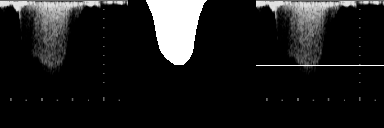

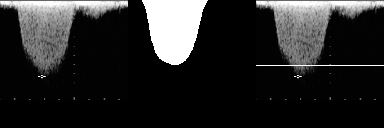

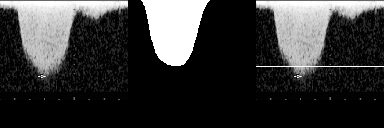

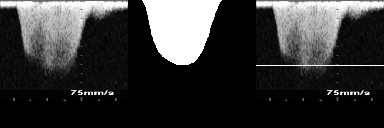

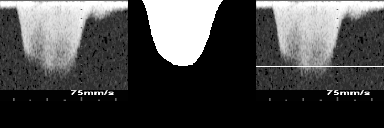

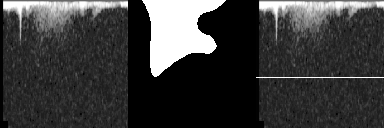

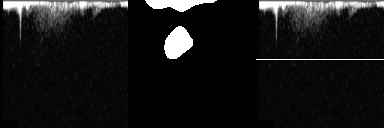

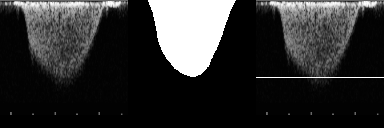

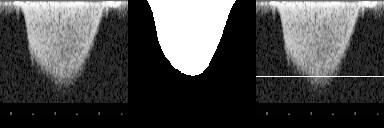

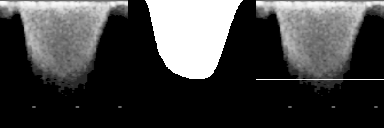

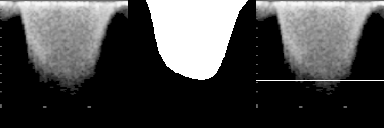

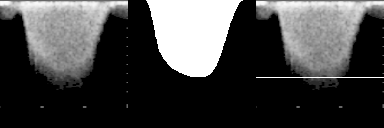

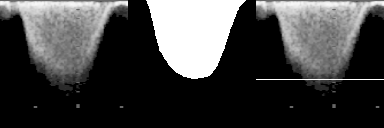

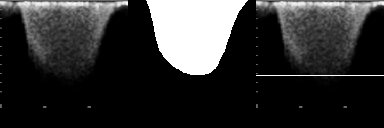

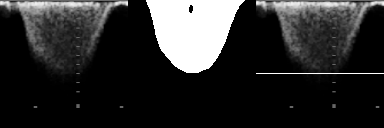

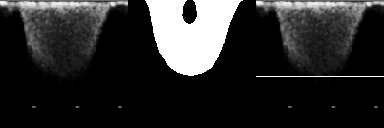

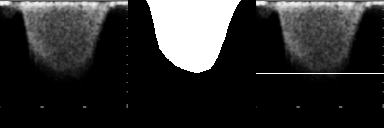

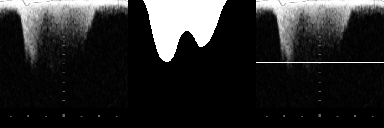

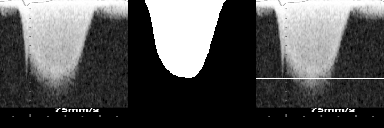

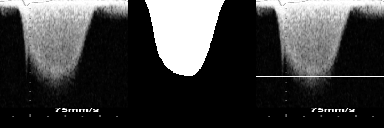

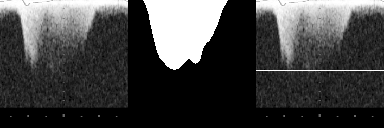

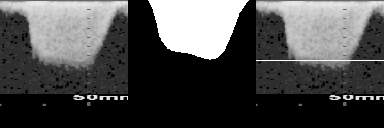

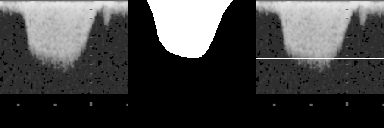

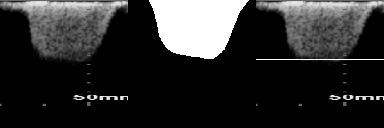

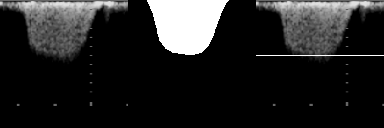

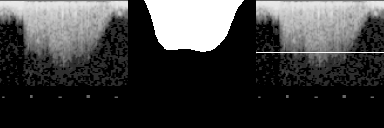

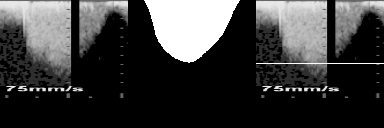

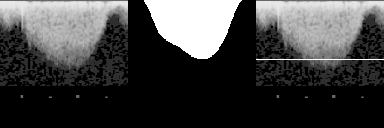

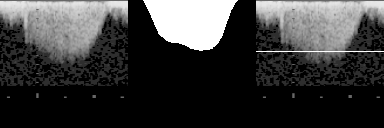

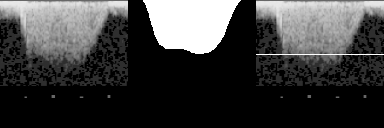

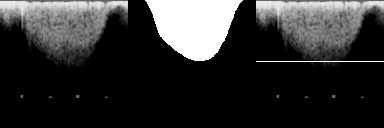

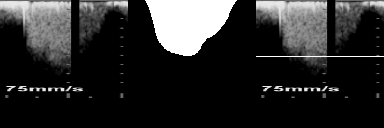

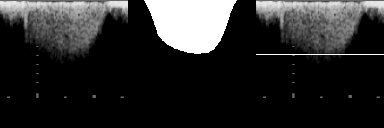

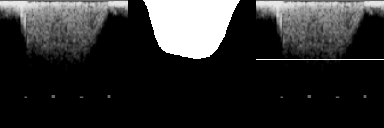

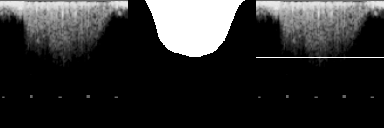

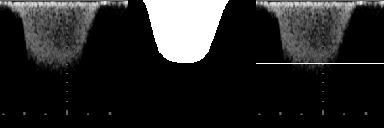

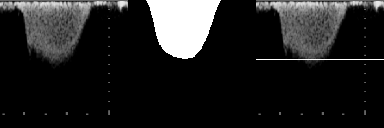

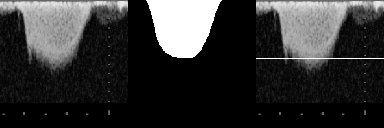

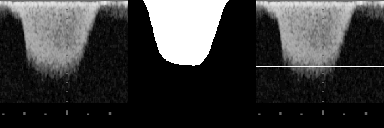

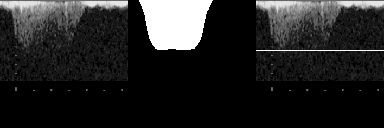

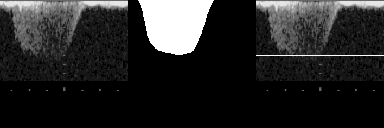

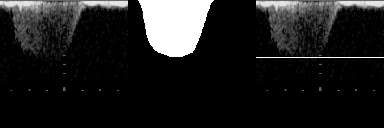

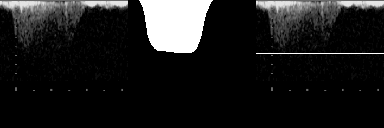

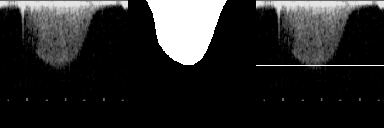

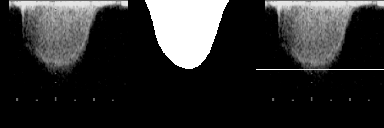

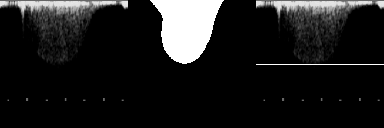

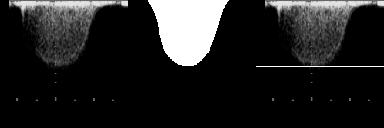

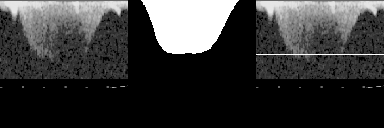

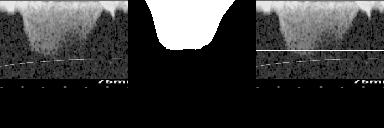

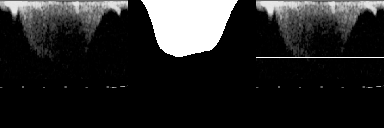

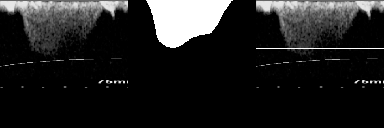

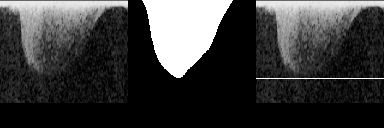

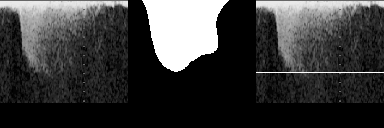

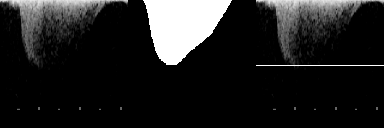

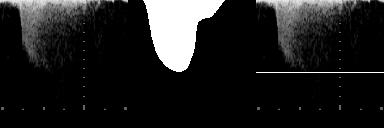

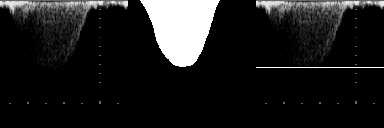

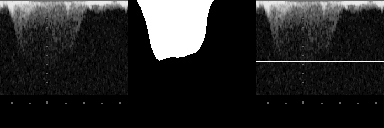

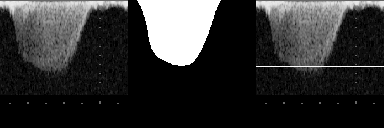

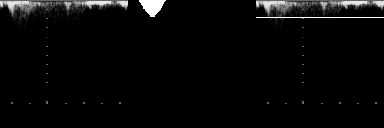

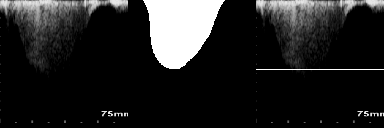

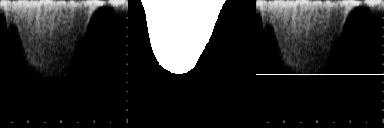

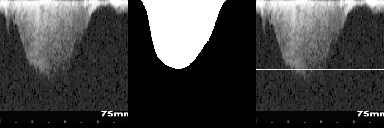

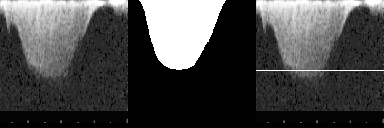

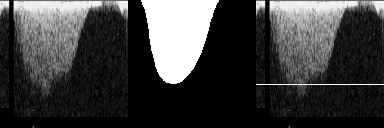

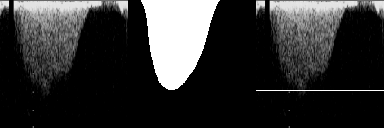

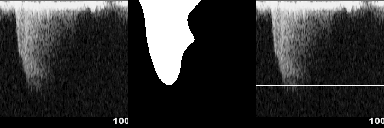

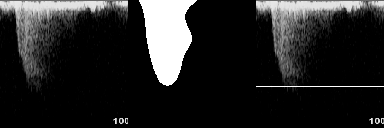

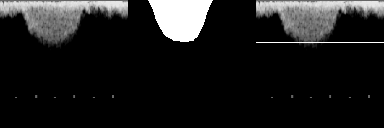

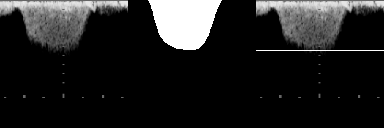

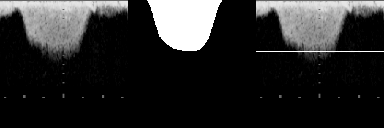

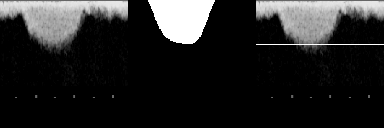

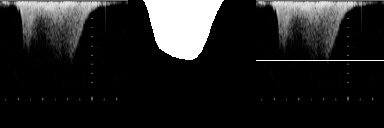

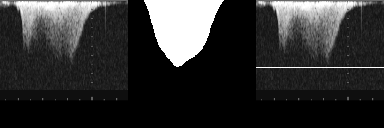

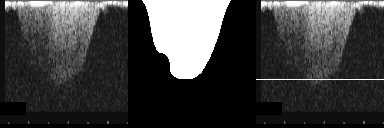

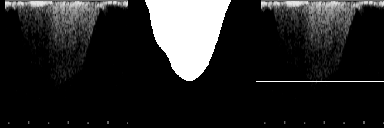

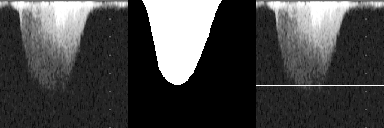

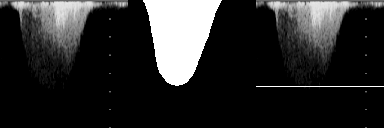

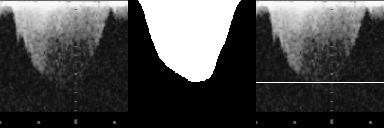

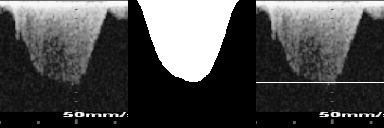

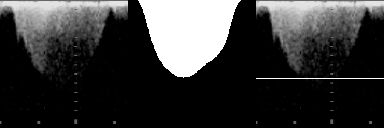

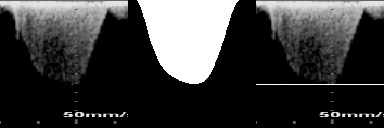

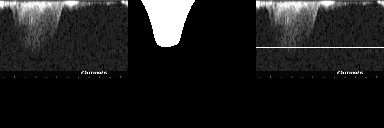

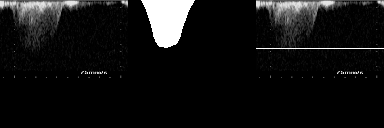

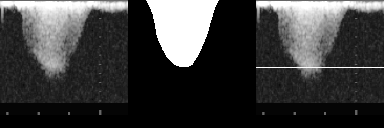

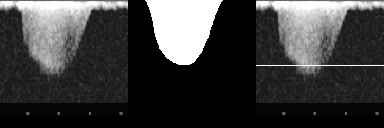

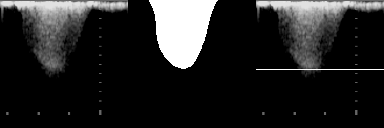

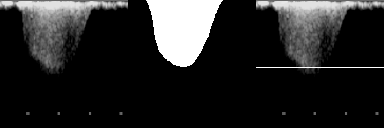

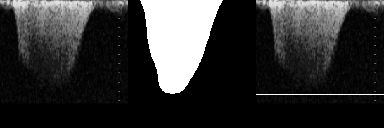

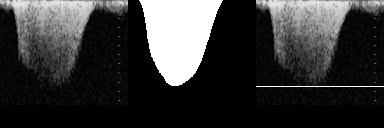

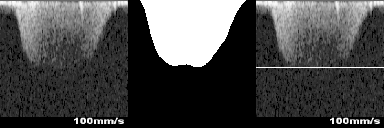

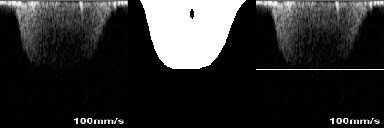

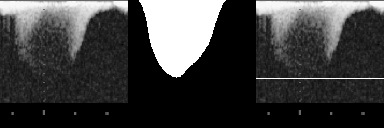

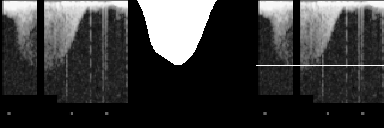

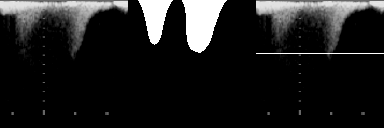

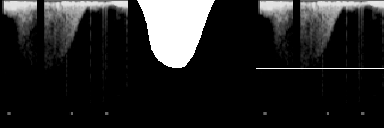

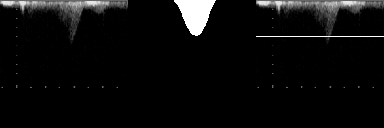

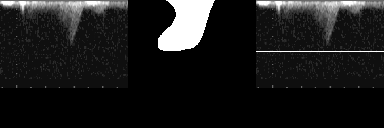

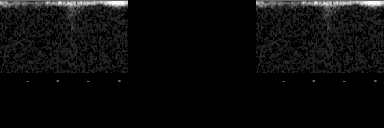

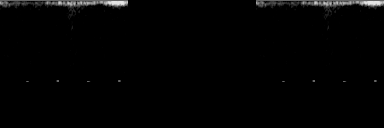

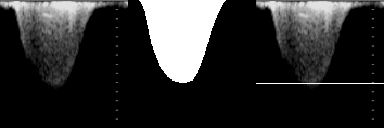

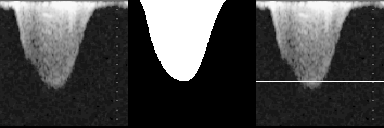

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

inputs = raws_nomatch

predictions = model.predict(inputs)

for i in range(108):
  denorm = inputs[i] * 255
  
  reshaped = predictions[i].reshape(IMAGE_SIZE, IMAGE_SIZE) * 255
  # Below 127 -> 0
  # Above 127 -> 255
  _,reshaped = cv2.threshold(reshaped,127,255,cv2.THRESH_BINARY)

  positions = cv2.findNonZero(cv2.flip(reshaped, 0))
  try: 
    bottom = positions[0][0][1]
  except:
    bottom = 0
  
  concat = np.concatenate([reshaped, cv2.line(np.copy(denorm), (0, IMAGE_SIZE - bottom), (IMAGE_SIZE, IMAGE_SIZE - bottom), (255), 1)], axis=1)
  
  with_prediction = np.concatenate((denorm, concat) , axis=1)
  cv2_imshow(with_prediction)


# Report

## Intepreting data and loading it

The data was throughougly studied to understand how to match each image with the given segmentation. Each image had a matching segmentation image, however, alot of them shared a segmentation image. This meant that each segmentation image had to be used twice in the training part of the model.

## Building the model

The model was based on the image under the "Setup Model" section. This is a standard U-NET model that follows the principle of disecting an image and rebuilding it up - a 'down-part' and an 'up-part'. However, following this model in the given image did not lead to particulary good result due to overfitting. This could have been caused by the images in the training set. To come around this issue, tweaking was made on the filter size parameters until a reasonable accuracy was achieved. 

## Training the model

Rougly 67% of the raw images had a matching segmentation mask. Among these there was a 80/20 split for train/test when training the model. This gave the model a fair amount of different kind of images to deveolop the high accuracy. 

## Testing the model

When testing was finished, there was still rougly 100 images that did not have a matching segmentation mask. These was used to visually test the models accuracy through prediction. In the section "Predict" we can see all of these cases and a remarkable accuracy in most of the images.

## Conclusion

The model was trained using a relatively broad set of training data, both in terms of type and quantity. Thus, the model was able to achieve an accuracy of around 98-99%. The model lacked accuracy on dark information due to the lack of training data. All in all, the model worked well on normal images.